In [ ]:
import os
import tensorflow as tf
import numpy as np
from google.colab import drive
# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED=1234
tf.random.set_seed(SEED)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cwd='/content/drive/My Drive/Kaggle1'
#cwd='/content/drive/My Drive/AN2DL'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input


apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        preprocessing_function=preprocess_input,
                                        validation_split=0.2)
else:
    train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                        validation_split=0.2) # set validation split

#the validation data generator
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


In [ ]:
dataset_dir='/content/drive/My Drive/Kaggle1/MaskDataset'
#dataset_dir='/content/drive/My Drive/AN2DL/MaskDataset'
train_dir=os.path.join(dataset_dir,'training')
valid_dir=os.path.join(dataset_dir,'training')
test_dir=os.path.join(dataset_dir,'test')

bs=16

# img shape
img_h = 512
img_w = 512
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    batch_size=bs,
    target_size=(img_h,img_w),
    class_mode='categorical', # targets are directly converted into one-hot vectors
    shuffle=True,seed=SEED,
    subset='training') # set as training data

validation_generator = train_data_gen.flow_from_directory(
    valid_dir, # same directory as training data
    batch_size=bs,
    target_size=(img_h,img_w),
    class_mode='categorical',
    subset='validation') # set as validation data


#train_generator.class_indices
num_classes=len(train_generator.class_indices)

train_dataset=tf.data.Dataset.from_generator(lambda:train_generator,output_types=(tf.float32,tf.float32),output_shapes=([None,img_h,img_w,3],[None,num_classes]))
train_dataset = train_dataset.repeat()

valid_dataset=tf.data.Dataset.from_generator(lambda:validation_generator,output_types=(tf.float32,tf.float32),output_shapes=([None,img_h,img_w,3],[None,num_classes]))
valid_dataset=valid_dataset.repeat()

Found 4492 images belonging to 3 classes.
Found 1122 images belonging to 3 classes.


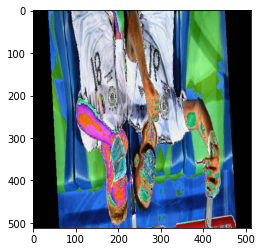

In [ ]:
#check
import matplotlib.pyplot as plt
%matplotlib inline

iterator=iter(train_dataset)
augmented_img,target=next(iterator)
augmented_img=np.array(augmented_img[0])*255 # denormalize

plt.imshow(np.uint8(augmented_img))
plt.show()

In [ ]:
#import the pretrained model
inception=tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))

inception.summary()

219062272/219055592 [==============================] - 6s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
_____________

In [ ]:
# Create Model
# ------------

finetuning = True

if finetuning:
    freeze_until = 450 # layer from which we want to fine-tune
    
    for layer in inception.layers[:freeze_until]:
        layer.trainable = False
else:
    inception.trainable = False
    
model = tf.keras.Sequential()
model.add(inception)
model.add(tf.keras.layers.GlobalMaxPooling2D(data_format=None))
model.add(tf.keras.layers.Dense(units=512,activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes,activation='softmax'))

# Visualize created model as a table
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 14, 14, 1536)      54336736  
_________________________________________________________________
global_max_pooling2d (Global (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 55,125,219
Trainable params: 38,344,419
Non-trainable params: 16,780,800
_________________________________________________________________


In [ ]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
    callbacks.append(es_callback)

# Learning rate adapter 
# --------------
lr_adapter = True
if lr_adapter:
    lr_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0,restore_best_weights=True)
    callbacks.append(lr_adapter_callback)

In [ ]:
#model training
model.fit(x=train_dataset,
          epochs=50, 
          steps_per_epoch=len(train_generator),
          validation_data=valid_dataset,
          validation_steps=len(validation_generator), 
          callbacks=callbacks)

Epoch 1/50
281/281 [==============================] - 2256s 8s/step - loss: 0.7420 - accuracy: 0.7021 - val_loss: 0.4940 - val_accuracy: 0.7959
Epoch 2/50
281/281 [==============================] - 418s 1s/step - loss: 0.3137 - accuracy: 0.8760 - val_loss: 0.2803 - val_accuracy: 0.8993
Epoch 3/50
281/281 [==============================] - 419s 1s/step - loss: 0.2199 - accuracy: 0.9212 - val_loss: 0.2688 - val_accuracy: 0.9020
Epoch 4/50
281/281 [==============================] - 422s 2s/step - loss: 0.1853 - accuracy: 0.9330 - val_loss: 0.3006 - val_accuracy: 0.8922
Epoch 5/50
281/281 [==============================] - 432s 2s/step - loss: 0.1607 - accuracy: 0.9426 - val_loss: 0.1955 - val_accuracy: 0.9367
Epoch 6/50
281/281 [==============================] - 430s 2s/step - loss: 0.1430 - accuracy: 0.9521 - val_loss: 0.2211 - val_accuracy: 0.9251
Epoch 7/50
281/281 [==============================] - 423s 2s/step - loss: 0.1161 - accuracy: 0.9577 - val_loss: 0.2677 - val_accuracy: 0.916

In [ ]:
#save model for final ensembling
model.save('/content/drive/My Drive/Kaggle1/TransferSavedModel/Inception_final')

In [ ]:
#evaluate optimal weights on validation set
val=model.evaluate(valid_dataset,steps=len(validation_generator),verbose=1)

71/71 [==============================] - 72s 1s/step - loss: 0.2063 - accuracy: 0.9385


In [ ]:
#compute predictions
from PIL import Image

final_path = os.path.join(dataset_dir, 'test')
image_filenames = next(os.walk(final_path))[2]  

results={} #empty dictionary 
for image_name in image_filenames:
  
   img=Image.open(final_path+'/'+image_name).convert('RGB')
   img=img.resize((img_h,img_w))
   img_array=np.array(img)
   img_array=preprocess_input(img_array)
   img_array=np.expand_dims(img_array, 0)
   prediction=np.argmax(model.predict(img_array))
   results[image_name]=prediction

In [ ]:
def create_csv(results, results_dir='./'):

    csv_fname = 'InceptionFinal'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')
create_csv(results,cwd)